# Batch Reactor Example
## Ignition delay computation

In this example we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure

The reactor (system) is simply an insulated box.

In [1]:
from __future__ import division
from __future__ import print_function

import numpy as np
import time

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.3.0a2


### Define the gas
In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species [mechanism](https://combustion.llnl.gov/archived-mechanisms/alkanes/heptane-reduced-mechanism) by [Seier et al. 2000, Proc. Comb. Inst](http://dx.doi.org/10.1016/S0082-0784&#40;00&#41;80610-4). 

In [2]:
gas = ct.Solution('data/seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in cp/R detected at Tmid = 1391
	Value computed using low-temperature polynomial:  53.0168
	Value computed using high-temperature polynomial: 52.748


**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [3]:
# Define the reactor temperature and pressure
reactorTemperature = 1000 #Kelvin
reactorPressure = 101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# now compile a list of all variables for which we will store data
stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]

# create a variable to store the state space time history
timeHistory = ct.SolutionArray(gas, extra=['t'])

### Define useful functions

In [4]:
def ignitionDelay(solArray, index):
    """
    This function computes the ignition delay from the occurence of the 
    peak in the concentration of species
    """
    return solArray.t[solArray.X[:,index].argmax()]

In [5]:
#Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimatedIgnitionDelayTime = 0.1
t = 0

counter = 1;
while(t < estimatedIgnitionDelayTime):
    t = reactorNetwork.step()
    if (counter%10 == 0):
        # We will save only every 10th value. Otherwise, this takes too long
        timeHistory.append(r.thermo.state, t=t)
    counter+=1

# We will now use 'oh' species to compute the ignition delay
tau = ignitionDelay(timeHistory, gas.species_index('oh'))

#Toc
t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

Computed Ignition Delay: 3.248e-02 seconds. Took 0.96s to compute


## Plot the result

### Import modules and set plotting defaults

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

### Figure illustrating the definition of ignition delay

<IPython.core.display.Javascript object>


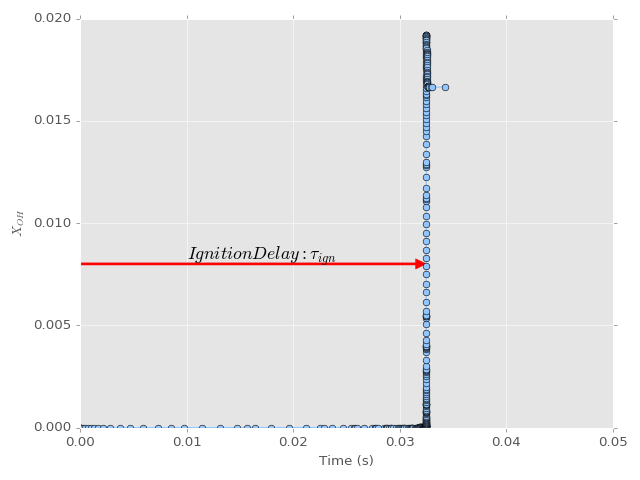

In [7]:
plt.figure()
plt.plot(timeHistory.t, timeHistory.X[:,gas.species_index('oh')],'-o')
plt.xlabel('Time (s)')
plt.ylabel('$X_{OH}$')

plt.xlim([0,0.05])
plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005, 
          head_length=0.001, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

## Illustration : NTC behavior
A common benchmark for a reaction mechanism is its ability to reproduce the **N**egative **T**emperature **C**oefficient behavior. Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. Reproducing experimentally observed NTC behavior is thus an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures

### Define the temperatures for which we will run the simulations

In [8]:
# Make a list of all the temperatures we would like to run simulations at
T = np.array([1800, 1600, 1400, 1200, 1000, 950, 925, 900, 850, 825, 800, 
     750, 700, 675, 650, 625, 612.25, 550, 500])

estimatedIgnitionDelayTimes = np.ones(len(T))*1

# Make time adjustments for the highest and lowest temperatures. We do this empirically
estimatedIgnitionDelayTimes[:6] = 6*[0.1]
estimatedIgnitionDelayTimes[-2:] = 10
estimatedIgnitionDelayTimes[-1] = 100

# Now create a dataFrame out of these
ignitionDelays = {'T': T, 'ignDelay': np.empty(T.shape)} 

Now, what we will do is simply run the code above the plots for each temperature.

In [9]:
for i, temperature in enumerate(T):

    # Setup the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 101325.0 
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    # Create and empty data frame
    timeHistory = ct.SolutionArray(gas, extra=['t'])
    
    #Tic
    t0 = time.time()
    
    estimatedIgnitionDelayTime = estimatedIgnitionDelayTimes[i]
    t = 0
    counter = 1;
    while(t < estimatedIgnitionDelayTime):
        t = reactorNetwork.step()
        if (counter%10 == 0):
            # We will save only every 10th value. Otherwise, this takes too long
            timeHistory.append(r.thermo.state, t=t)
        counter+=1

    tau = ignitionDelay(timeHistory, gas.species_index('oh'))     
    
    #Toc
    t1 = time.time()
    
    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, temperature, t1-t0))
    
    ignitionDelays['ignDelay'][i] = tau

Computed Ignition Delay: 3.140e-05 seconds for T=1800.0K. Took 0.75s to compute
Computed Ignition Delay: 4.086e-05 seconds for T=1600.0K. Took 0.87s to compute
Computed Ignition Delay: 1.648e-04 seconds for T=1400.0K. Took 0.74s to compute
Computed Ignition Delay: 1.632e-03 seconds for T=1200.0K. Took 0.86s to compute
Computed Ignition Delay: 3.248e-02 seconds for T=1000.0K. Took 1.07s to compute
Computed Ignition Delay: 7.909e-02 seconds for T=950.0K. Took 0.93s to compute
Computed Ignition Delay: 1.252e-01 seconds for T=925.0K. Took 1.07s to compute
Computed Ignition Delay: 1.983e-01 seconds for T=900.0K. Took 1.01s to compute
Computed Ignition Delay: 4.266e-01 seconds for T=850.0K. Took 1.14s to compute
Computed Ignition Delay: 4.726e-01 seconds for T=825.0K. Took 1.19s to compute
Computed Ignition Delay: 3.795e-01 seconds for T=800.0K. Took 1.20s to compute
Computed Ignition Delay: 1.462e-01 seconds for T=750.0K. Took 1.37s to compute
Computed Ignition Delay: 6.427e-02 seconds for 

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

<IPython.core.display.Javascript object>


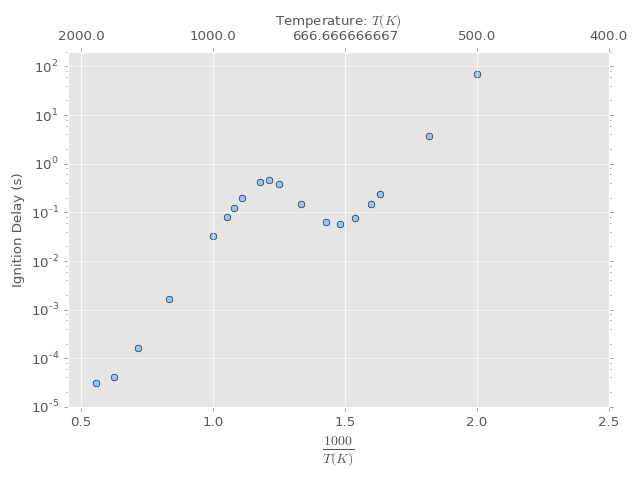

In [10]:
fig = plt.figure()
plt.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o')

plt.ylim([1e-5, 200])
plt.xlim([0.45, 2.5])

plt.ylabel('Ignition Delay (s)')
plt.xlabel(r'$\frac{1000}{T (K)}$', fontsize=18);

# Add a second axis on top to plot the temperature for better readability
ax = fig.add_subplot(111)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

topAxisTicks = np.array([0.5, 1.0, 1.5, 2.0, 2.5])
ax2.set_xticks(topAxisTicks)
ax2.set_xticklabels(1000.0/topAxisTicks)
ax2.set_xlabel(r'Temperature: $T(K)$');